# 07 - Modelo con Feature Engineering SIMPLIFICADO + LightGBM

Este notebook implementa **feature engineering conservador** con solo las features más robustas.

**Objetivo:** Mejorar generalización y score en Kaggle

In [1]:
!pip install lightgbm -q
print("LightGBM instalado")

✓ LightGBM instalado


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print(" Librerías importadas")

✓ Librerías importadas


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (692500, 21)
Test: (296786, 20)


## Preprocesamiento + Feature Engineering SIMPLIFICADO

In [4]:
def preprocess_simplified(df, is_train=True):
    """
    Preprocesamiento + Feature Engineering SIMPLIFICADO.
    Solo features robustas que generalizan bien.
    """
    df_copy = df.copy()

    # Guardar ID y target
    ids = df_copy['ID'].copy()
    if is_train:
        target = df_copy['RENDIMIENTO_GLOBAL'].copy()

    # Eliminar columnas
    cols_to_drop = ['ID']
    if is_train:
        cols_to_drop.append('RENDIMIENTO_GLOBAL')
    df_copy = df_copy.drop(cols_to_drop, axis=1)

    # ===== PREPROCESAMIENTO BASE =====

    valor_orden = {
        'Menos de 500 mil': 0,
        'Entre 500 mil y menos de 1 millón': 1,
        'Entre 1 millón y menos de 2.5 millones': 2,
        'Entre 2.5 millones y menos de 4 millones': 3,
        'Entre 4 millones y menos de 5.5 millones': 4,
        'Entre 5.5 millones y menos de 7 millones': 5,
        'Más de 7 millones': 6
    }
    df_copy['E_VALORMATRICULAUNIVERSIDAD'] = df_copy['E_VALORMATRICULAUNIVERSIDAD'].map(valor_orden)

    horas_orden = {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4
    }
    df_copy['E_HORASSEMANATRABAJA'] = df_copy['E_HORASSEMANATRABAJA'].map(horas_orden)

    estrato_map = {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    }
    df_copy['F_ESTRATOVIVIENDA'] = df_copy['F_ESTRATOVIVIENDA'].map(estrato_map)

    educacion_orden = {
        'Ninguno': 0,
        'Primaria incompleta': 1,
        'Primaria completa': 2,
        'Secundaria (Bachillerato) incompleta': 3,
        'Secundaria (Bachillerato) completa': 4,
        'Técnica o tecnológica incompleta': 5,
        'Técnica o tecnológica completa': 6,
        'Educación profesional incompleta': 7,
        'Educación profesional completa': 8,
        'Postgrado': 9,
        'No sabe': 2
    }
    df_copy['F_EDUCACIONPADRE'] = df_copy['F_EDUCACIONPADRE'].map(educacion_orden)
    df_copy['F_EDUCACIONMADRE'] = df_copy['F_EDUCACIONMADRE'].map(educacion_orden)

    binary_map = {'Si': 1, 'No': 0, 'S': 1, 'N': 0}
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL',
                   'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'E_PAGOMATRICULAPROPIO']

    for col in binary_cols:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].map(binary_map)

    df_copy['E_PRIVADO_LIBERTAD'] = df_copy['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0})

    # Label Encoding
    le_programa = LabelEncoder()
    le_depto = LabelEncoder()

    df_copy['E_PRGM_ACADEMICO'] = le_programa.fit_transform(df_copy['E_PRGM_ACADEMICO'].astype(str))
    df_copy['E_PRGM_DEPARTAMENTO'] = le_depto.fit_transform(df_copy['E_PRGM_DEPARTAMENTO'].astype(str))

    # Imputar antes de crear features
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_copy[col].isna().sum() > 0:
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())

    # ===== FEATURE ENGINEERING SIMPLIFICADO =====

    print("\nCreando features robustas...")

    # 1. Solo 2 interacciones clave
    df_copy['IND_1x2'] = df_copy['INDICADOR_1'] * df_copy['INDICADOR_2']
    df_copy['IND_3x4'] = df_copy['INDICADOR_3'] * df_copy['INDICADOR_4']

    # 2. Agregaciones simples
    df_copy['IND_SUM'] = df_copy['INDICADOR_1'] + df_copy['INDICADOR_2'] + df_copy['INDICADOR_3'] + df_copy['INDICADOR_4']
    df_copy['IND_MEAN'] = df_copy['IND_SUM'] / 4
    df_copy['IND_STD'] = df_copy[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].std(axis=1)

    # 3. Score socioeconómico conservador
    df_copy['SOCIOECONOMIC_SCORE'] = (
        df_copy['F_ESTRATOVIVIENDA'].fillna(0) * 2 +
        df_copy['F_EDUCACIONPADRE'].fillna(0) +
        df_copy['F_EDUCACIONMADRE'].fillna(0) +
        df_copy['F_TIENEINTERNET'].fillna(0) * 2 +
        df_copy['F_TIENECOMPUTADOR'].fillna(0) * 2
    )

    # 4. Solo promedio de educación familiar
    df_copy['EDU_PARENTS_MEAN'] = df_copy[['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']].mean(axis=1)

    # Rellenar NaNs
    df_copy = df_copy.fillna(0)

    print(f"✓ {df_copy.shape[1]} features totales (8 nuevas)")

    # Agregar ID
    df_copy.insert(0, 'ID', ids)

    if is_train:
        df_copy['RENDIMIENTO_GLOBAL'] = target

    return df_copy

print("✓ Función definida")

✓ Función definida


In [5]:
# Aplicar
print("Preprocesando train...")
df_train_processed = preprocess_simplified(df_train, is_train=True)

print("\nPreprocesando test...")
df_test_processed = preprocess_simplified(df_test, is_train=False)

print(f"\nTrain: {df_train_processed.shape}")
print(f"Test: {df_test_processed.shape}")

Preprocesando train...

Creando features robustas...
✓ 26 features totales (8 nuevas)

Preprocesando test...

Creando features robustas...
✓ 26 features totales (8 nuevas)

Train: (692500, 28)
Test: (296786, 27)


In [6]:
# Preparar datos
X = df_train_processed.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)
y = df_train_processed['RENDIMIENTO_GLOBAL']

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

test_ids = df_test_processed['ID'].copy()
X_test = df_test_processed.drop(['ID'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Features: {X_train.shape[1]}")

Train: (554000, 26)
Val: (138500, 26)
Features: 26


## Entrenar LightGBM - Configuración CONSERVADORA

In [7]:
# Datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Configuración MÁS CONSERVADORA para evitar overfitting
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 50,            # Reducido (era 80)
    'learning_rate': 0.03,        # Un poco más rápido
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 40,
    'max_depth': 10,             # Reducido (era 12)
    'reg_alpha': 0.2,            # Más regularización
    'reg_lambda': 0.2,
    'verbose': -1,
    'seed': 42
}

print("Entrenando LightGBM (configuración conservadora)...\n")

model = lgb.train(
    params,
    train_data,
    num_boost_round=400,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=40), lgb.log_evaluation(period=50)]
)

# Evaluar
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n{'='*60}")
print(f"RESULTADOS - FEATURE ENGINEERING SIMPLIFICADO")
print(f"{'='*60}")
print(f"Accuracy en validación: {val_acc:.5f}")
print(f"Árboles: {model.best_iteration}")
print(f"\nComparación:")
print(f"  Ensemble (05): 0.41497")
print(f"  FE completo (06): 0.41267")
print(f"  FE simple (06v2): {val_acc:.5f}")

if val_acc > 0.41497:
    print(f"\n✓ MEJOR QUE ENSEMBLE: +{(val_acc - 0.41497):.5f}")
elif val_acc > 0.41267:
    print(f"\n✓ Mejor que FE completo: +{(val_acc - 0.41267):.5f}")
else:
    print(f"\n⚠ No mejoró, usar Ensemble (05)")

Entrenando LightGBM (configuración conservadora)...

Training until validation scores don't improve for 40 rounds
[50]	train's multi_logloss: 1.25626	valid's multi_logloss: 1.25878
[100]	train's multi_logloss: 1.22821	valid's multi_logloss: 1.23272
[150]	train's multi_logloss: 1.21436	valid's multi_logloss: 1.22077
[200]	train's multi_logloss: 1.20578	valid's multi_logloss: 1.21425
[250]	train's multi_logloss: 1.19983	valid's multi_logloss: 1.21047
[300]	train's multi_logloss: 1.19513	valid's multi_logloss: 1.20809
[350]	train's multi_logloss: 1.19105	valid's multi_logloss: 1.20628
[400]	train's multi_logloss: 1.18761	valid's multi_logloss: 1.20513
Did not meet early stopping. Best iteration is:
[400]	train's multi_logloss: 1.18761	valid's multi_logloss: 1.20513

RESULTADOS - FEATURE ENGINEERING SIMPLIFICADO
Accuracy en validación: 0.43303
Árboles: 400

Comparación:
  Ensemble (05): 0.41497
  FE completo (06): 0.41267
  FE simple (06v2): 0.43303

✓ MEJOR QUE ENSEMBLE: +0.01806



Reporte de clasificación:

              precision    recall  f1-score   support

        alto       0.55      0.63      0.58     35124
        bajo       0.46      0.57      0.51     34597
  medio-alto       0.33      0.26      0.29     34324
  medio-bajo       0.33      0.26      0.30     34455

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.42    138500
weighted avg       0.42      0.43      0.42    138500



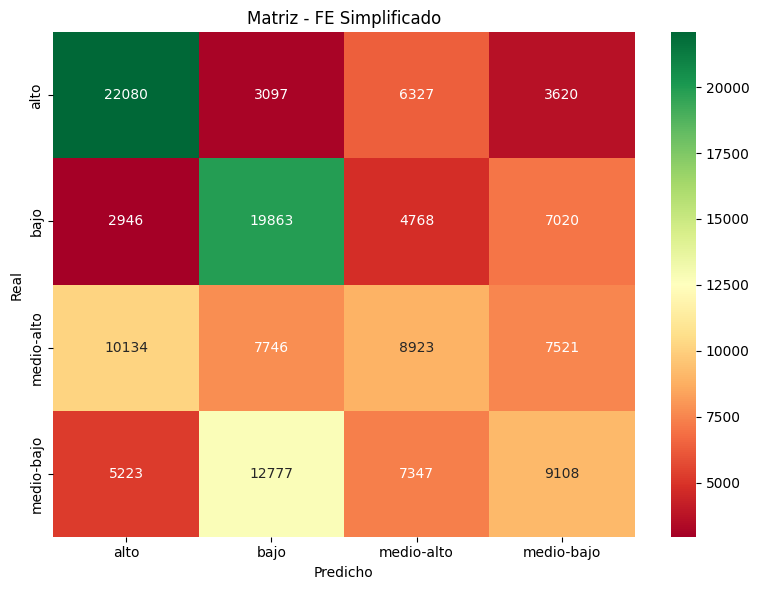

In [8]:
# Reporte
y_val_labels = le_target.inverse_transform(y_val)
y_val_pred_labels = le_target.inverse_transform(y_val_pred)

print("\nReporte de clasificación:\n")
print(classification_report(y_val_labels, y_val_pred_labels))

cm = confusion_matrix(y_val_labels, y_val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'],
            yticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'])
plt.title('Matriz - FE Simplificado')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## Generar predicciones

In [9]:
# Entrenar modelo final
print("Entrenando modelo final...\n")

full_train_data = lgb.Dataset(X, label=y_encoded)

model_final = lgb.train(
    params,
    full_train_data,
    num_boost_round=model.best_iteration,
    callbacks=[lgb.log_evaluation(period=50)]
)

print("\n Modelo final listo")

Entrenando modelo final...


✓ Modelo final listo


In [10]:
# Predicciones
print("Generando predicciones...")

y_test_pred_proba = model_final.predict(X_test)
y_test_pred_encoded = np.argmax(y_test_pred_proba, axis=1)
y_test_pred = le_target.inverse_transform(y_test_pred_encoded)

submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

submission.to_csv('submission_fe_simple.csv', index=False)

print(f"\n{'='*60}")
print(f"✓ submission_fe_simple.csv GENERADO")
print(f"{'='*60}")
print(f"\nPredicciones: {len(submission)}")
print(f"\nDistribución:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts())
print(f"\n{'='*60}")
print(f"LISTO PARA KAGGLE")
print(f"{'='*60}")
print(f"Accuracy validación: {val_acc:.5f}")
print(f"Features usadas: 8 nuevas (solo las robustas)")

Generando predicciones...

✓ submission_fe_simple.csv GENERADO

Predicciones: 296786

Distribución:
RENDIMIENTO_GLOBAL
alto          90705
bajo          87741
medio-alto    61880
medio-bajo    56460
Name: count, dtype: int64

LISTO PARA KAGGLE
Accuracy validación: 0.43303
Features usadas: 8 nuevas (solo las robustas)


## Resumen

**Features creadas (8 total):**
1. IND_1x2, IND_3x4 (interacciones clave)
2. IND_SUM, IND_MEAN, IND_STD (agregaciones)
3. SOCIOECONOMIC_SCORE
4. EDU_PARENTS_MEAN

**Eliminado (vs versión anterior):**
- Estadísticas por departamento
- Ratios complejos
- Interacciones excesivas

**Configuración más conservadora:**
- num_leaves: 50 (vs 80)
- max_depth: 10 (vs 12)
- Más regularización

**Objetivo:** Mejor generalización en Kaggle